In [1]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

base_path = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

if base_path not in sys.path:
    sys.path.insert(0, base_path)

from app.app_config import AppConfig
from infra.spark.spark_session import SparkSessionFactory

spark = SparkSessionFactory.create("pipelines-process")

✅ SparkSession ready | mode=local | spark=3.5.6
Driver python: C:\Users\Praca\AppData\Local\Programs\Python\Python312\python.exe
Executor python: C:\Users\Praca\AppData\Local\Programs\Python\Python312\python.exe


In [2]:
from app.app_config import AppConfig

gold_df = (
    spark.read
    .format("delta")
    .load(AppConfig.GOLD_FEATURES_PATH)
)

gold_df.printSchema()


root
 |-- simulation_id: string (nullable = true)
 |-- step: integer (nullable = true)
 |-- simulation_time: double (nullable = true)
 |-- rpm: double (nullable = true)
 |-- speed_kmh: double (nullable = true)
 |-- throttle: double (nullable = true)
 |-- brake: double (nullable = true)
 |-- gear: integer (nullable = true)
 |-- coolant_temp_c: double (nullable = true)
 |-- oil_temp_c: double (nullable = true)
 |-- wear_engine: double (nullable = true)
 |-- wear_gearbox: double (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- rpm_avg_30s: double (nullable = true)
 |-- rpm_std_30s: double (nullable = true)
 |-- rpm_avg_60s: double (nullable = true)
 |-- rpm_delta_30s: double (nullable = true)
 |-- coolant_temp_c_avg_30s: double (nullable = true)
 |-- coolant_temp_c_delta_30s: double (nullable = true)
 |-- throttle_avg_30s: double (nullable = true)
 |-- throttle_std_30s: double (nullable = true)
 |-- wear_engine_delta_60s: double (nullable = true)
 |-- has_full_window_30

In [3]:
gold_df.select("simulation_id").distinct().show(truncate=False)

SIM_ID = "413af5eb-5ab8-438f-b8e1-5b210dcd2828"

one_gold_df = (
    gold_df
    .filter(f"simulation_id = '{SIM_ID}'")
    .orderBy("step")
)

one_gold_df.count()


+------------------------------------+
|simulation_id                       |
+------------------------------------+
|75b1b44c-b1ae-422e-90b1-66027ac4de75|
|413af5eb-5ab8-438f-b8e1-5b210dcd2828|
|0c7b9175-e73e-44d7-8ce2-ea750bacdcf0|
|549cf669-e30d-40c3-8c1d-71037b426a14|
|127876df-3a18-47ad-a65b-ffedab1df14c|
|c43d99ce-7afb-4f56-988b-6b6c5b1c49d0|
+------------------------------------+



1674

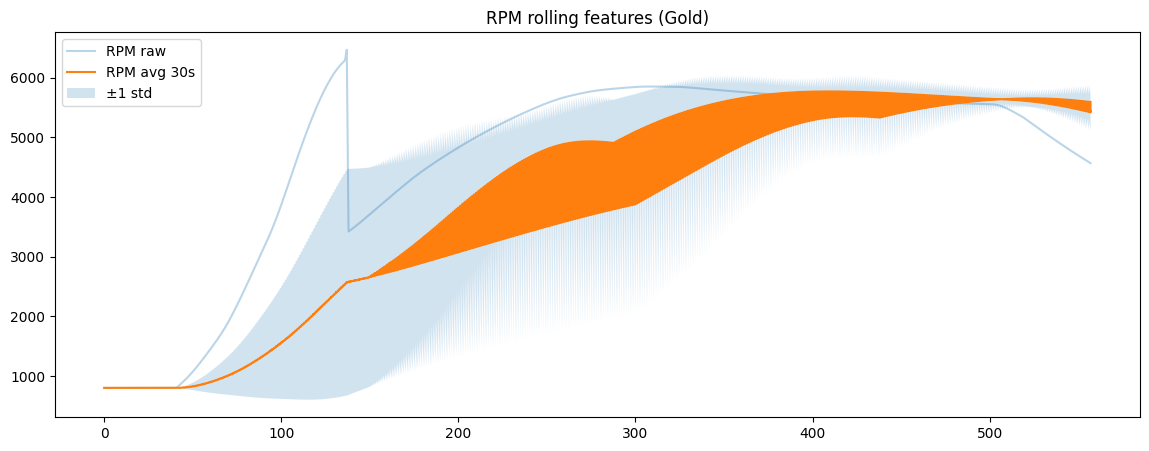

In [4]:
pdf = (
    one_gold_df
    .select(
        "step",
        "rpm",
        "rpm_avg_30s",
        "rpm_std_30s"
    )
    .toPandas()
)

plt.figure(figsize=(14,5))
plt.plot(pdf["step"], pdf["rpm"], alpha=0.3, label="RPM raw")
plt.plot(pdf["step"], pdf["rpm_avg_30s"], label="RPM avg 30s")
plt.fill_between(
    pdf["step"],
    pdf["rpm_avg_30s"] - pdf["rpm_std_30s"],
    pdf["rpm_avg_30s"] + pdf["rpm_std_30s"],
    alpha=0.2,
    label="±1 std"
)
plt.legend()
plt.title("RPM rolling features (Gold)")
plt.show()


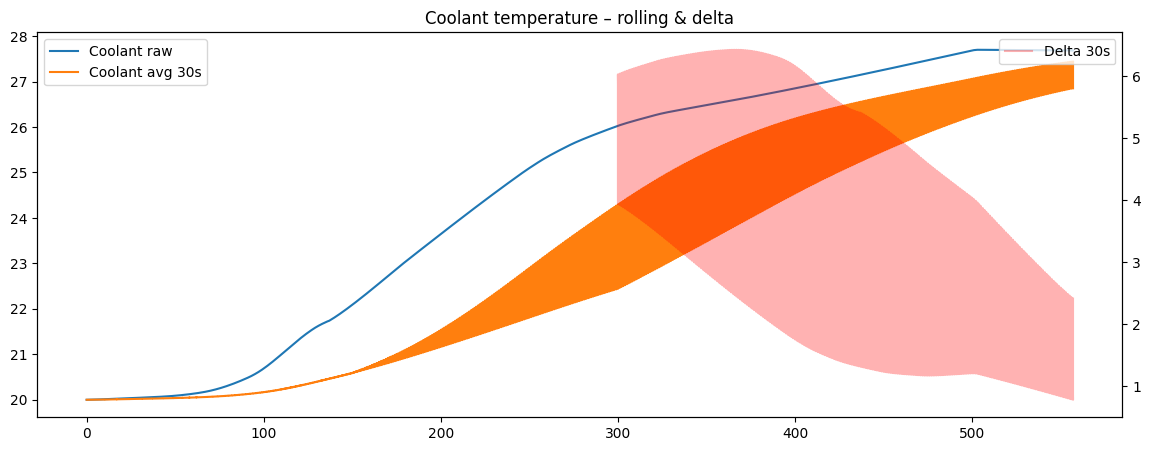

In [5]:
pdf = (
    one_gold_df
    .select(
        "step",
        "coolant_temp_c",
        "coolant_temp_c_avg_30s",
        "coolant_temp_c_delta_30s"
    )
    .toPandas()
)

fig, ax1 = plt.subplots(figsize=(14,5))

ax1.plot(pdf["step"], pdf["coolant_temp_c"], label="Coolant raw")
ax1.plot(pdf["step"], pdf["coolant_temp_c_avg_30s"], label="Coolant avg 30s")

ax2 = ax1.twinx()
ax2.plot(pdf["step"], pdf["coolant_temp_c_delta_30s"], color="red", alpha=0.3, label="Delta 30s")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title("Coolant temperature – rolling & delta")
plt.show()


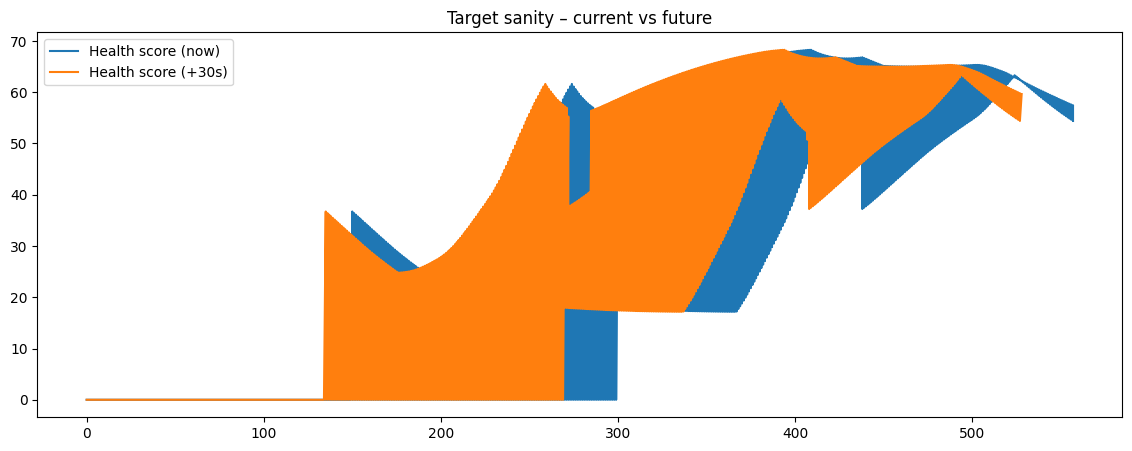

In [6]:
pdf = (
    one_gold_df
    .select(
        "step",
        "engine_health_score",
        "engine_health_score_future"
    )
    .toPandas()
)

plt.figure(figsize=(14,5))
plt.plot(pdf["step"], pdf["engine_health_score"], label="Health score (now)")
plt.plot(pdf["step"], pdf["engine_health_score_future"], label="Health score (+30s)")
plt.legend()
plt.title("Target sanity – current vs future")
plt.show()


In [7]:
from ml.datasets.feature_config import FEATURE_COLUMNS, TARGET_COLUMN

ml_df = (
    gold_df
    .filter("is_gold_sane = true")
    .filter("has_full_window_30s = true")
    .filter("has_future_label = true")
    .select(FEATURE_COLUMNS + [TARGET_COLUMN])
)

pdf = ml_df.toPandas()

X = pdf[FEATURE_COLUMNS]
y = pdf[TARGET_COLUMN]


In [8]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

model.fit(X, y)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",8
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples a

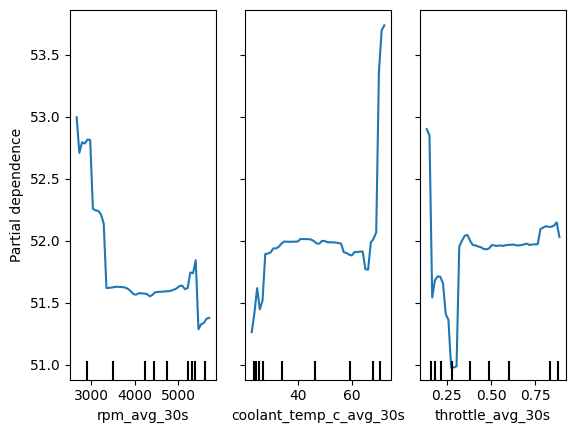

In [9]:
from sklearn.inspection import PartialDependenceDisplay

features_to_check = [
    "rpm_avg_30s",
    "coolant_temp_c_avg_30s",
    "throttle_avg_30s"
]

PartialDependenceDisplay.from_estimator(
    model,
    X,
    features_to_check,
    grid_resolution=50
)

plt.show()


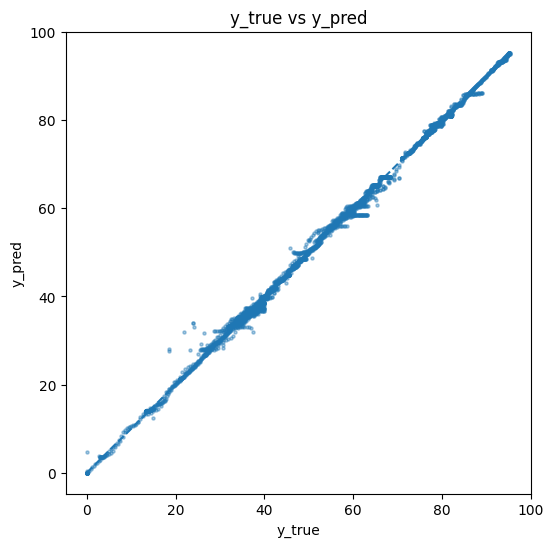

In [10]:
y_pred = model.predict(X)

plt.figure(figsize=(6,6))
plt.scatter(y, y_pred, s=5, alpha=0.4)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "--")
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.title("y_true vs y_pred")
plt.show()
